<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_Result_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [19]:
print(len(mel_path_list))

print(len(ground_truth_list))

split_index = int(0.8 * len(mel_path_list))

print(split_index)

mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_test = mel_path_list[split_index:]
ground_truth_list_test = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [21]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_test = Batched_Preloader(mel_path_list_test, ground_truth_list_test, 128)
preloader_test.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [32]:
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_3.npy').tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_3.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-01 17:35:32
Mean Train Loss: 0.0943780158150052
Mean Evaluation Loss: 0.07938428828089646
-------------------------------------------------------------------------------------------------------
09-01 17:35:52
Mean Train Loss: 0.0768753546661497
Mean Evaluation Loss: 0.0769357159366159
-------------------------------------------------------------------------------------------------------
09-01 17:36:13
Mean Train Loss: 0.07501196559464139
Mean Evaluation Loss: 0.0756511272964312
-------------------------------------------------------------------------------------------------------
09-01 17:36:34
Mean Train Loss: 0.07409323405059937
Mean Evaluation Loss: 0.07470410670722157
-------------------------------------------------------------------------------------------------------
09-01 17:36:54
Mean Train Loss: 0.07341941237843644
Mean Evaluation Loss: 0.07437651056616115
-------------------------------------------------------------------------------------------------------


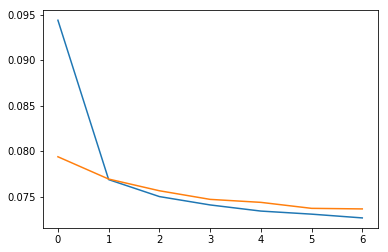

아-------------------------------------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos>
아다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


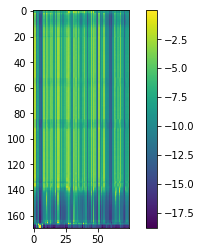

아-------------------------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos>
아다.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


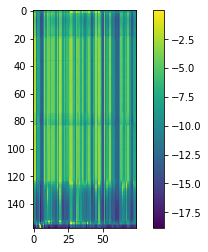

-------------------------------------------------------------------------------------------------------
09-01 17:37:56
Mean Train Loss: 0.07258184330709412
Mean Evaluation Loss: 0.07340156531531775
-------------------------------------------------------------------------------------------------------
09-01 17:38:16
Mean Train Loss: 0.07229666670515429
Mean Evaluation Loss: 0.0734232517252949
-------------------------------------------------------------------------------------------------------
09-01 17:38:37
Mean Train Loss: 0.0720620683668713
Mean Evaluation Loss: 0.072977106664569
-------------------------------------------------------------------------------------------------------
09-01 17:38:57
Mean Train Loss: 0.07016580375577572
Mean Evaluation Loss: 0.0631257590503156
-------------------------------------------------------------------------------------------------------
09-01 17:39:18
Mean Train Loss: 0.0647269866456299
Mean Evaluation Loss: 0.062195582524848116
---------------

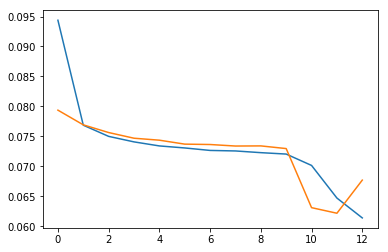

이------으----으---은---아---으----이----으----으---아----으----아----으----ᄋ----으----아---아---으----아----아---으----아---으---이----아-------------------------------------------다.<eos><eos>
이으으은아으이으으아으아으ᄋ으아아으아아으아으이아다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


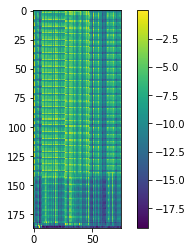

아니-----ᅳᆫ---은---은---으----으---은---으----으----으---으----으----으----아----으----이---이----아---이---------------------------------------------아.<eos><eos>
아니ᅳᆫ은은으으은으으으으으으아으이이아이아.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


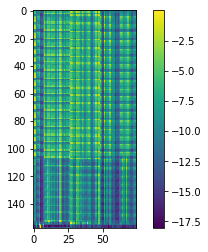

-------------------------------------------------------------------------------------------------------
09-01 17:40:00
Mean Train Loss: 0.06356080843398038
Mean Evaluation Loss: 0.06260450000424622
-------------------------------------------------------------------------------------------------------
09-01 17:40:20
Mean Train Loss: 0.06124935981522068
Mean Evaluation Loss: 0.07581153965865692
-------------------------------------------------------------------------------------------------------
09-01 17:40:40
Mean Train Loss: 0.07310723566904609
Mean Evaluation Loss: 0.06825594133679343
-------------------------------------------------------------------------------------------------------
09-01 17:41:02
Mean Train Loss: 0.06415021612251158
Mean Evaluation Loss: 0.06724205672056355
-------------------------------------------------------------------------------------------------------
09-01 17:41:22
Mean Train Loss: 0.06420040166990267
Mean Evaluation Loss: 0.0630459611816875
-----------

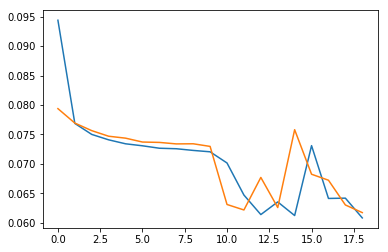

아-----------------------으--아--아--아--아--아--ᄋ-------아--아--아--아--아--아--아--아--아--아--아------아--아--아--아--아--아--아--아--아--이----------------------다.<eos><eos>
아으아아아아아ᄋ아아아아아아아아아아아아아아아아아아아아이다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


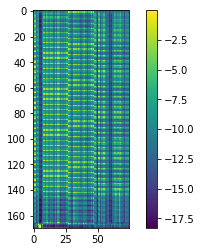

아-------------------아--아--아--아--아--아--아--아--아--아--아--아------아--아--아--아--아--아--아--아--아----------------------------------------------다.<eos><eos>
아아아아아아아아아아아아아아아아아아아아아아다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


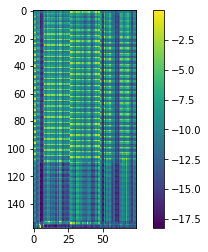

-------------------------------------------------------------------------------------------------------
09-01 17:42:03
Mean Train Loss: 0.06018930192534542
Mean Evaluation Loss: 0.06193520656467825
-------------------------------------------------------------------------------------------------------
09-01 17:42:23
Mean Train Loss: 0.0601686182213885
Mean Evaluation Loss: 0.06159038661983355
-------------------------------------------------------------------------------------------------------
09-01 17:42:43
Mean Train Loss: 0.06007196253300911
Mean Evaluation Loss: 0.06132987074545891
-------------------------------------------------------------------------------------------------------
09-01 17:43:04
Mean Train Loss: 0.06127143775029157
Mean Evaluation Loss: 0.06289749279382599
-------------------------------------------------------------------------------------------------------
09-01 17:43:24
Mean Train Loss: 0.06093384427499404
Mean Evaluation Loss: 0.06233146620878709
-----------

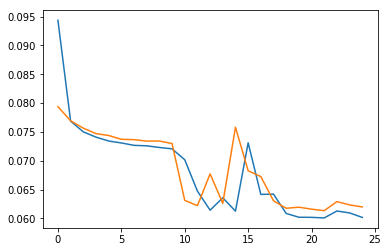

아----------으--아--아--아--아--아--아--아--ᄋ-------아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--이--------------------------------------------------------------------다.<eos><eos>
아으아아아아아아아ᄋ아아아아아아아아아아아아아아아이다.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


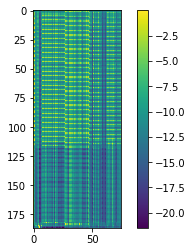

아--------------느--아--아--아--으--으--아--아--아--아--아--아--아--아--아--ᄋ---아--아--아--아--아--아--아--아--아--아--이-------------------------------다.<eos><eos>
아느아아아으으아아아아아아아아아ᄋ아아아아아아아아아아이다.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


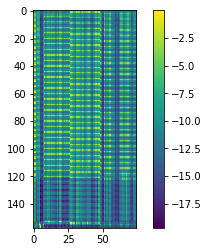

-------------------------------------------------------------------------------------------------------
09-01 17:44:05
Mean Train Loss: 0.06013159632412323
Mean Evaluation Loss: 0.061040106178842264
-------------------------------------------------------------------------------------------------------
09-01 17:44:25
Mean Train Loss: 0.06002026353394217
Mean Evaluation Loss: 0.06102768835990348
-------------------------------------------------------------------------------------------------------
09-01 17:44:46
Mean Train Loss: 0.05987124370805286
Mean Evaluation Loss: 0.06118137516203444
-------------------------------------------------------------------------------------------------------
09-01 17:45:06
Mean Train Loss: 0.060647988114033866
Mean Evaluation Loss: 0.06309788811329924
-------------------------------------------------------------------------------------------------------
09-01 17:45:27
Mean Train Loss: 0.06107229568119572
Mean Evaluation Loss: 0.06328036702711966
--------

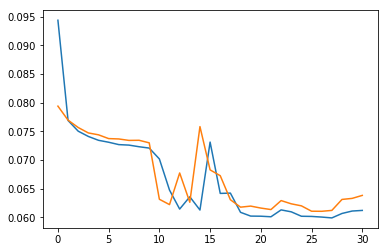

아------------아---으--아---아--아---아--아--아---아--아--아---아---아--아--아---아---아--아--아--아---아--아---아--아---아--아--아----------------------------------다.<eos><eos>
아아으아아아아아아아아아아아아아아아아아아아아아아아아아다.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


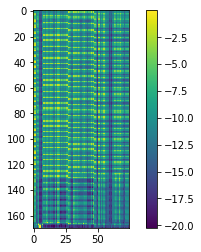

아--느---으--아---아--아--아---아--아---아--아--아---아--아--아---아--아---아--아---아--아--아---아--아--아----------------------------------------------다.<eos><eos>
아느으아아아아아아아아아아아아아아아아아아아아아아다.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


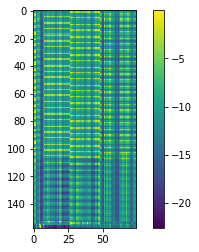

-------------------------------------------------------------------------------------------------------
09-01 17:46:08
Mean Train Loss: 0.06067463370164587
Mean Evaluation Loss: 0.06123312713824487
-------------------------------------------------------------------------------------------------------
09-01 17:46:28
Mean Train Loss: 0.05983393797664367
Mean Evaluation Loss: 0.06125059817118526
-------------------------------------------------------------------------------------------------------
09-01 17:46:48
Mean Train Loss: 0.06010526202346622
Mean Evaluation Loss: 0.060996197940749744
-------------------------------------------------------------------------------------------------------
09-01 17:47:08
Mean Train Loss: 0.0599358946411041
Mean Evaluation Loss: 0.06088831974938092
-------------------------------------------------------------------------------------------------------
09-01 17:47:28
Mean Train Loss: 0.05988196420971121
Mean Evaluation Loss: 0.06032708120644718
----------

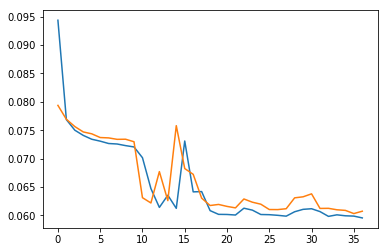

아------------------아--아--아--아--아--아--아--으--으----------아--아--아--아--아--아--아--아--아--아--아--아--아--아--이------------------------------------------------------------다.<eos><eos>
아아아아아아아아으으아아아아아아아아아아아아아아이다.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


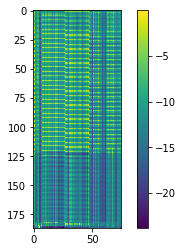

아------------------아--아--아--아--아--아--아--아--아--아--아--아--으-------ᅡ--아--아--아--아--아--있-ᄋ------------------------------------------------다.<eos><eos>
아아아아아아아아아아아아아으ᅡ아아아아아있ᄋ다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


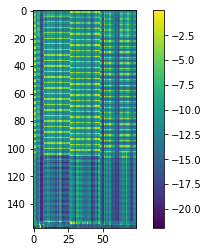

-------------------------------------------------------------------------------------------------------
09-01 17:48:09
Mean Train Loss: 0.0596676785057995
Mean Evaluation Loss: 0.060304264513583374
-------------------------------------------------------------------------------------------------------
09-01 17:48:30
Mean Train Loss: 0.05950132412549649
Mean Evaluation Loss: 0.06022830729090193
-------------------------------------------------------------------------------------------------------
09-01 17:48:50
Mean Train Loss: 0.059433650551328536
Mean Evaluation Loss: 0.05996526743908674
-------------------------------------------------------------------------------------------------------
09-01 17:49:10
Mean Train Loss: 0.05945704255066362
Mean Evaluation Loss: 0.05984250937693564
-------------------------------------------------------------------------------------------------------
09-01 17:49:30
Mean Train Loss: 0.059264836205439764
Mean Evaluation Loss: 0.05984332406427836
--------

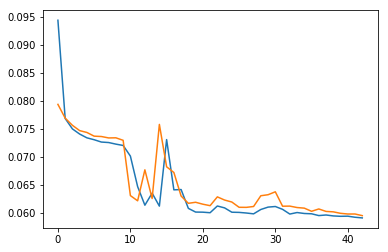

아--------------아--아--아--아--으--아--아--아--으--으--은 아----------으--아--아--아--아--아--아--아--아--으--아--있---------------------------------------------------------------다.<eos><eos>
아아아아아으아아아으으은 아으아아아아아아아아으아있다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


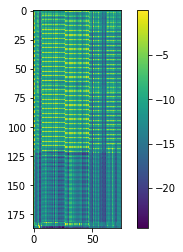

아--------------으--아--아--으--으- ----아--아--아--아--아--아--아--아--아--으- ᄋ---아--아--아--아--이---------------------------------------------------요.<eos><eos>
아으아아으으 아아아아아아아아아으 ᄋ아아아아이요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


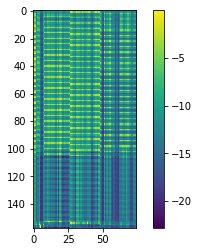

-------------------------------------------------------------------------------------------------------
09-01 17:50:12
Mean Train Loss: 0.05890730214744616
Mean Evaluation Loss: 0.05949751216997311
-------------------------------------------------------------------------------------------------------
09-01 17:50:32
Mean Train Loss: 0.05890389472994886
Mean Evaluation Loss: 0.05981355303634974
-------------------------------------------------------------------------------------------------------
09-01 17:50:52
Mean Train Loss: 0.05880258368375546
Mean Evaluation Loss: 0.05928658426412093
-------------------------------------------------------------------------------------------------------
09-01 17:51:13
Mean Train Loss: 0.05852985874624501
Mean Evaluation Loss: 0.05916922117859523
-------------------------------------------------------------------------------------------------------
09-01 17:51:33
Mean Train Loss: 0.05817368570680191
Mean Evaluation Loss: 0.05877286603099424
----------

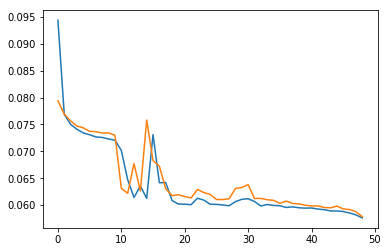

자----------으--아--아--아--으--으--으--으--은 아------으--이--사--으--으--이--시--이--으--으--이--으--아--아--아--아--아--입-이-----------------------------------다.<eos><eos>
자으아아아으으으으은 아으이사으으이시이으으이으아아아아아입이다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


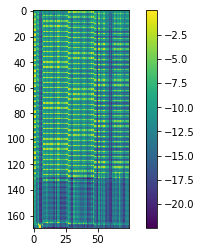

으----------으--이--아--은 아--아--아--아--사--아--아--사--이--이--으--으- 기--으--이--시--아--아--아--어-----------------------------------------------요.<eos><eos>
으으이아은 아아아아사아아사이이으으 기으이시아아아어요.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


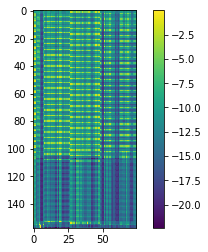

-------------------------------------------------------------------------------------------------------
09-01 17:52:14
Mean Train Loss: 0.05697361604473567
Mean Evaluation Loss: 0.05766156653342805
-------------------------------------------------------------------------------------------------------
09-01 17:52:34
Mean Train Loss: 0.056690997517717494
Mean Evaluation Loss: 0.05768570327550569
-------------------------------------------------------------------------------------------------------
09-01 17:52:54
Mean Train Loss: 0.056289008856339834
Mean Evaluation Loss: 0.05725110279835337
-------------------------------------------------------------------------------------------------------
09-01 17:53:15
Mean Train Loss: 0.055636480980856655
Mean Evaluation Loss: 0.05611305348753222
-------------------------------------------------------------------------------------------------------
09-01 17:53:35
Mean Train Loss: 0.05515118634794023
Mean Evaluation Loss: 0.0563031890207338
--------

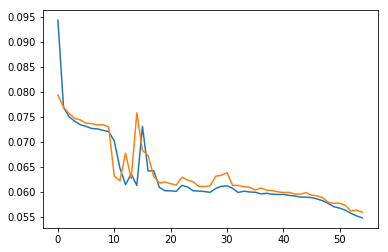

저--------------으--아--사--아--아--아--사--서--사--이--사--아--으--이--아--아--아--으--아--으--아------아--시--아--이--아--어--------------------------------------------------------요.<eos><eos>
저으아사아아아사서사이사아으이아아아으아으아아시아이아어요.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


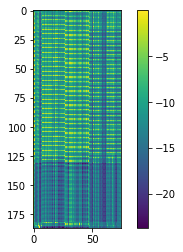

저-------ᅳ--으--이--이--아--아--아--으--시--아--아--아--으--아- 아--아--으--이--이--으--아--아--어-------------------------------------------------------요.<eos><eos>
저ᅳ으이이아아아으시아아아으아 아아으이이으아아어요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


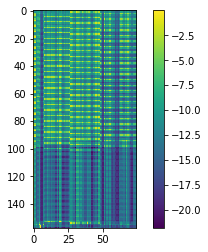

-------------------------------------------------------------------------------------------------------
09-01 17:54:17
Mean Train Loss: 0.05423903311558058
Mean Evaluation Loss: 0.05462002936555208
-------------------------------------------------------------------------------------------------------
09-01 17:54:37
Mean Train Loss: 0.05349727804761475
Mean Evaluation Loss: 0.05398972530335772
-------------------------------------------------------------------------------------------------------
09-01 17:54:57
Mean Train Loss: 0.05280309698214233
Mean Evaluation Loss: 0.05355403848749113
-------------------------------------------------------------------------------------------------------
09-01 17:55:17
Mean Train Loss: 0.052168337846178844
Mean Evaluation Loss: 0.05279766319073462
-------------------------------------------------------------------------------------------------------
09-01 17:55:37
Mean Train Loss: 0.051654373304045695
Mean Evaluation Loss: 0.05205307043616263
--------

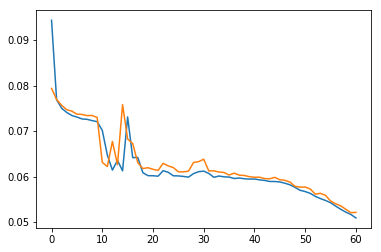

우--------------으--는 은-으--으--으--으--으--으--으--가--으--으--고--아--이--이--으- 지--지--지--아--사--사--사--으--아--아--이--십-니--------------------------------------------다.<eos><eos>
우으는 은으으으으으으으가으으고아이이으 지지지아사사사으아아이십니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


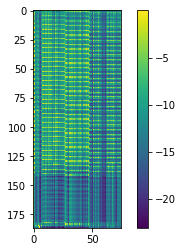

그------사--사--사--으--시--시--이--아--아--이--이--아--아--으--에--아- 아--시--시--으--으--아--으- 으--이--아--아--어-----------------------------------요.<eos><eos>
그사사사으시시이아아이이아아으에아 아시시으으아으 으이아아어요.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


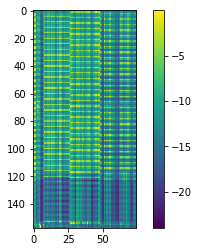

-------------------------------------------------------------------------------------------------------
09-01 17:56:18
Mean Train Loss: 0.05067494075265053
Mean Evaluation Loss: 0.05079087876977949
-------------------------------------------------------------------------------------------------------
09-01 17:56:38
Mean Train Loss: 0.049510519713243
Mean Evaluation Loss: 0.05015330309259766
-------------------------------------------------------------------------------------------------------
09-01 17:56:58
Mean Train Loss: 0.0489729199469345
Mean Evaluation Loss: 0.04950485092933654
-------------------------------------------------------------------------------------------------------
09-01 17:57:18
Mean Train Loss: 0.048087754415859545
Mean Evaluation Loss: 0.0488406158537006
-------------------------------------------------------------------------------------------------------
09-01 17:57:39
Mean Train Loss: 0.04764612482482792
Mean Evaluation Loss: 0.048483721858902484
------------

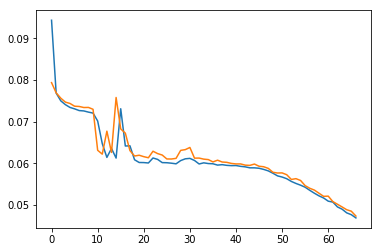

나----------------------느--으- 서--아--자--ᄉ---이- 가--수--즈- 오------가--이- 시--시--하--으--아--이- 디--기--강-자--이--으- 지--하--합--------------------------다.<eos><eos>
나느으 서아자ᄉ이 가수즈 오가이 시시하으아이 디기강자이으 지하합다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


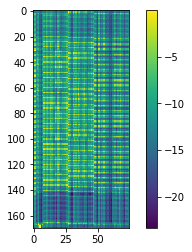

이----------이--으--으--으--으- 이--사--으--으--아--으--으--다--다--이- 고--가--사--아--오--이--이--었--------------------------------------------------다.<eos><eos>
이이으으으으 이사으으아으으다다이 고가사아오이이었다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


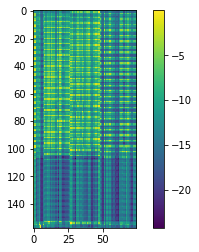

-------------------------------------------------------------------------------------------------------
09-01 17:58:20
Mean Train Loss: 0.04616638640012692
Mean Evaluation Loss: 0.046607112340130874
-------------------------------------------------------------------------------------------------------
09-01 17:58:40
Mean Train Loss: 0.04523024892207308
Mean Evaluation Loss: 0.04612569335090307
-------------------------------------------------------------------------------------------------------
09-01 17:59:00
Mean Train Loss: 0.0447237215411268
Mean Evaluation Loss: 0.04558023586975003
-------------------------------------------------------------------------------------------------------
09-01 17:59:22
Mean Train Loss: 0.044493199549665303
Mean Evaluation Loss: 0.0455258948370047
-------------------------------------------------------------------------------------------------------
09-01 17:59:42
Mean Train Loss: 0.04370317454200713
Mean Evaluation Loss: 0.0438968189021106
-----------

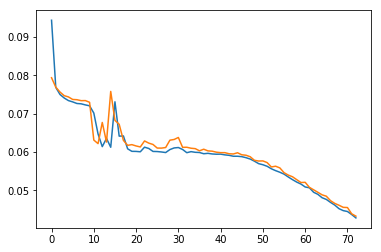

우----------ᄅ---느--은 고--안 다--단 즈--조--이--주--은 므------소--아- 아--거--거--다- 마--마--이- 안-드--해--읍-니------------------------------------------------------------다.<eos><eos>
우ᄅ느은 고안 다단 즈조이주은 므소아 아거거다 마마이 안드해읍니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


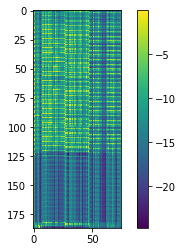

우--ᄅ---리- 애--에--으--는 이--이--이- 아--서--으--이--아- 가--으--하- 거--자- 하--아--하--하- 있-습-니-----------------------------------------------다.<eos><eos>
우ᄅ리 애에으는 이이이 아서으이아 가으하 거자 하아하하 있습니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


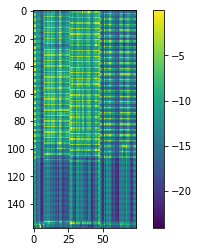

-------------------------------------------------------------------------------------------------------
09-01 18:00:23
Mean Train Loss: 0.04211078598819504
Mean Evaluation Loss: 0.042534604680491056
-------------------------------------------------------------------------------------------------------
09-01 18:00:43
Mean Train Loss: 0.04144534517357318
Mean Evaluation Loss: 0.042408732934060264
-------------------------------------------------------------------------------------------------------
09-01 18:01:03
Mean Train Loss: 0.041194219680692125
Mean Evaluation Loss: 0.04153324167703119
-------------------------------------------------------------------------------------------------------
09-01 18:01:23
Mean Train Loss: 0.04030141037486067
Mean Evaluation Loss: 0.04139683350855135
-------------------------------------------------------------------------------------------------------
09-01 18:01:44
Mean Train Loss: 0.03981410497681413
Mean Evaluation Loss: 0.040686220416008605
------

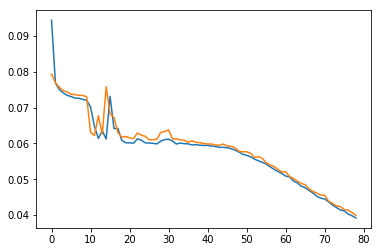

해--------------ᄋ-- 오--고--가- 정-애--뎌- 이--이--이--개--어- 사--상-아--여--머--오- 가--지--이--이--어- 며--혀- 있-었------------------------------------------다.<eos><eos>
해ᄋ 오고가 정애뎌 이이이개어 사상아여머오 가지이이어 며혀 있었다.<eos>
해외로부터 전염병이 유입되어 확산되는 것을 방지하기 위한 노력이 있었다.<eos>-------------------


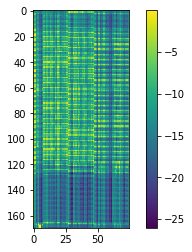

여----------먼 아--아--안-아--에- 여--우--언-만-아--드--에- 서--을-을 반-므--하--고 -있----------------------------------------------------------다.<eos><eos>
여먼 아아안아에 여우언만아드에 서을을 반므하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


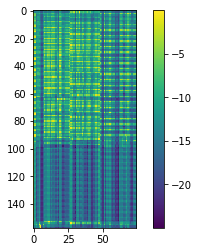

-------------------------------------------------------------------------------------------------------
09-01 18:02:25
Mean Train Loss: 0.038689341667873
Mean Evaluation Loss: 0.03935226246028088
-------------------------------------------------------------------------------------------------------
09-01 18:02:45
Mean Train Loss: 0.038070935222537385
Mean Evaluation Loss: 0.03935277548178941
-------------------------------------------------------------------------------------------------------
09-01 18:03:06
Mean Train Loss: 0.0377146897224801
Mean Evaluation Loss: 0.0385358570625527
-------------------------------------------------------------------------------------------------------
09-01 18:03:26
Mean Train Loss: 0.037161171955766
Mean Evaluation Loss: 0.03740510699055294
-------------------------------------------------------------------------------------------------------
09-01 18:03:46
Mean Train Loss: 0.036488396575216325
Mean Evaluation Loss: 0.037006217025848755
-------------

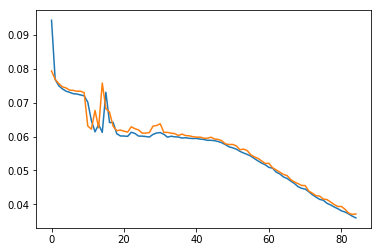

않-------------으--년-여---ᅩ- 주--으- 소--서--에--서- 겨--형-이--한 지--우--으- 기--걱-은 고------성-에--이--서--저--이--안 오--수---------------------------다.<eos><eos>
않으년여ᅩ 주으 소서에서 겨형이한 지우으 기걱은 고성에이서저이안 오수다.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


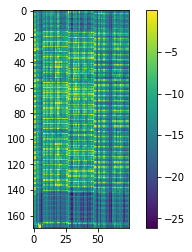

왜------시--사--으--을 디--드--으--에- 가--하--르--로- 저--드--롤 고--하--르--고  서---ᅥ--랄 수--했-어-----------------------------------------------요.<eos><eos>
왜시사으을 디드으에 가하르로 저드롤 고하르고 서ᅥ랄 수했어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


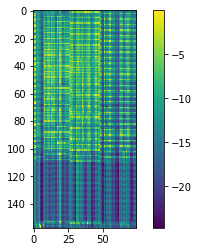

-------------------------------------------------------------------------------------------------------
09-01 18:04:27
Mean Train Loss: 0.03548216307931803
Mean Evaluation Loss: 0.037644113002658665
-------------------------------------------------------------------------------------------------------
09-01 18:04:47
Mean Train Loss: 0.03513184107735379
Mean Evaluation Loss: 0.036111159001431296
-------------------------------------------------------------------------------------------------------
09-01 18:05:07
Mean Train Loss: 0.03489490739052258
Mean Evaluation Loss: 0.036415697046608825
-------------------------------------------------------------------------------------------------------
09-01 18:05:27
Mean Train Loss: 0.034229751511632156
Mean Evaluation Loss: 0.035407223393878785
-------------------------------------------------------------------------------------------------------
09-01 18:05:47
Mean Train Loss: 0.03393249516411924
Mean Evaluation Loss: 0.03490650236593299
-----

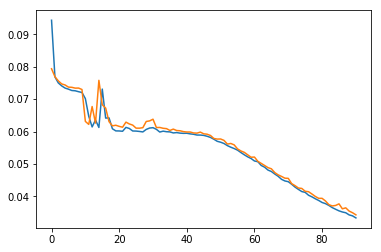

부------마--저--저--늘 늘--ᅳᆯ 시--실-종-다--가--는 자----------이- 아--으--을 다--를 지- 마--가--가- 기--할-는 것-시--------------------------------------------------------다.<eos><eos>
부마저저늘 늘ᅳᆯ 시실종다가는 자이 아으을 다를 지 마가가 기할는 것시다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


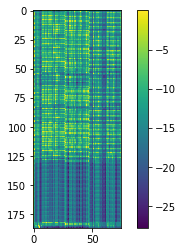

요------ᄌ---지--에--은 구--사--아--서- 추--이--에- 겅-기--가- 대--강-한 자--이--형-고--고  않-아---------------------------------------------------요.<eos><eos>
요ᄌ지에은 구사아서 추이에 겅기가 대강한 자이형고고 않아요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


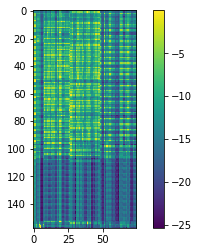

-------------------------------------------------------------------------------------------------------
09-01 18:06:28
Mean Train Loss: 0.03288287010823226
Mean Evaluation Loss: 0.03444089710944854
-------------------------------------------------------------------------------------------------------
09-01 18:06:49
Mean Train Loss: 0.03263064479250931
Mean Evaluation Loss: 0.03431952281045193
-------------------------------------------------------------------------------------------------------
09-01 18:07:09
Mean Train Loss: 0.03213707656517045
Mean Evaluation Loss: 0.033010123020936026
-------------------------------------------------------------------------------------------------------
09-01 18:07:30
Mean Train Loss: 0.031729548641898024
Mean Evaluation Loss: 0.033329867367152634
-------------------------------------------------------------------------------------------------------
09-01 18:07:50
Mean Train Loss: 0.031534558043355906
Mean Evaluation Loss: 0.032664825181250946
-----

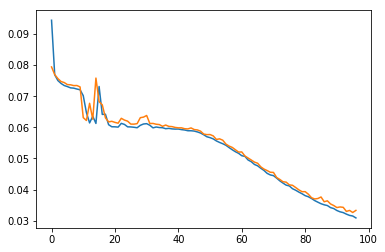

저--------------의- 애--정-ᄋ-- 복-북-목-기--이- 부--기--기--ᄋ---새--고- 사--식-쿠--색-트--다--이- 하--이- 판-내--으--합-니----------------------------------------------------다.<eos><eos>
저의 애정ᄋ 복북목기이 부기기ᄋ새고 사식쿠색트다이 하이 판내으합니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


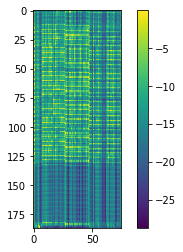

저----------는 그--사--라--이- 아--여--이- 여--자--를-을 달-를 태--도--가- 마--으- 안-들-아-------------------------------------------------------요.<eos><eos>
저는 그사라이 아여이 여자를을 달를 태도가 마으 안들아요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


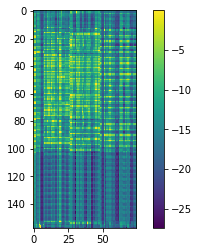

-------------------------------------------------------------------------------------------------------
09-01 18:08:32
Mean Train Loss: 0.030583598852799227
Mean Evaluation Loss: 0.03272179033688699
-------------------------------------------------------------------------------------------------------
09-01 18:08:52
Mean Train Loss: 0.030621579909369027
Mean Evaluation Loss: 0.032137343463228205
-------------------------------------------------------------------------------------------------------
09-01 18:09:12
Mean Train Loss: 0.030139897471734966
Mean Evaluation Loss: 0.03203812966055679
-------------------------------------------------------------------------------------------------------
09-01 18:09:32
Mean Train Loss: 0.029665873895914296
Mean Evaluation Loss: 0.0318027523801871
-------------------------------------------------------------------------------------------------------
09-01 18:09:52
Mean Train Loss: 0.029636281272012163
Mean Evaluation Loss: 0.031616289287666875
----

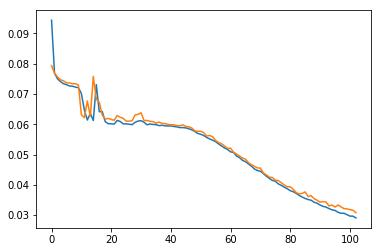

오--리--리- 아--아--이- 가--구--아- 아--저--주--저- 아--를-할 시--이--에--데--어- 영-먼-허--름-게- 새--각-합-니-----------------------------------------------다.<eos><eos>
오리리 아아이 가구아 아저주저 아를할 시이에데어 영먼허름게 새각합니다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


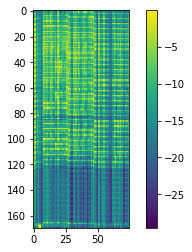

내------새--가--기--는 이--루--오--으- 가--려--들-드- 는 기--아--한-게- 어--은 것-갔--------------------------------------------------------------다.<eos><eos>
내새가기는 이루오으 가려들드 는 기아한게 어은 것갔다.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


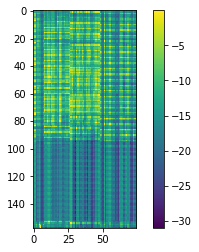

-------------------------------------------------------------------------------------------------------
09-01 18:10:33
Mean Train Loss: 0.02885982583551639
Mean Evaluation Loss: 0.03046391040130441
-------------------------------------------------------------------------------------------------------
09-01 18:10:53
Mean Train Loss: 0.029007771095976843
Mean Evaluation Loss: 0.03178539864842946
-------------------------------------------------------------------------------------------------------
09-01 18:11:14
Mean Train Loss: 0.02863514775319603
Mean Evaluation Loss: 0.03044977825258563
-------------------------------------------------------------------------------------------------------
09-01 18:11:34
Mean Train Loss: 0.028873720670309275
Mean Evaluation Loss: 0.030378289486896085
-------------------------------------------------------------------------------------------------------
09-01 18:11:54
Mean Train Loss: 0.02784307388546926
Mean Evaluation Loss: 0.030393982271076498
------

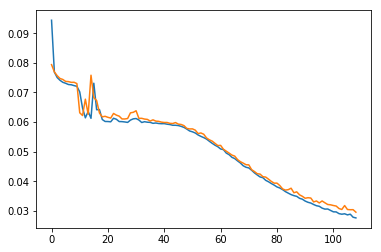

부--모--가- 저--르--는 흔 시- 시--주--가--나--는 자----------이- 아--이--를 다--른 지- 아--가- 기--기--가--는 거--시------------------------------------------------------------다.<eos><eos>
부모가 저르는 흔 시 시주가나는 자이 아이를 다른 지 아가 기기가는 거시다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


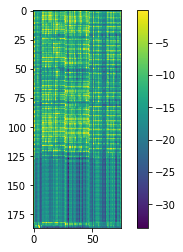

한---------국-게--오- 고--으--는 자--지--에--에- 에- 안-만-마--은 거--이  오--하--은 것 앝-아---------------------------------------------------요.<eos><eos>
한국게오 고으는 자지에에 에 안만마은 거이 오하은 것 앝아요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


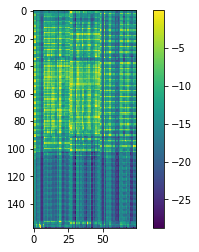

-------------------------------------------------------------------------------------------------------
09-01 18:12:36
Mean Train Loss: 0.02766789916302015
Mean Evaluation Loss: 0.030281949462941996
-------------------------------------------------------------------------------------------------------
09-01 18:12:56
Mean Train Loss: 0.027816088072544633
Mean Evaluation Loss: 0.030052522860937604
-------------------------------------------------------------------------------------------------------
09-01 18:13:16
Mean Train Loss: 0.02751452526732473
Mean Evaluation Loss: 0.0294818769639572
-------------------------------------------------------------------------------------------------------
09-01 18:13:36
Mean Train Loss: 0.026949532305799512
Mean Evaluation Loss: 0.029304795896276707
-------------------------------------------------------------------------------------------------------
09-01 18:13:56
Mean Train Loss: 0.026652490286370775
Mean Evaluation Loss: 0.029164126877397317
----

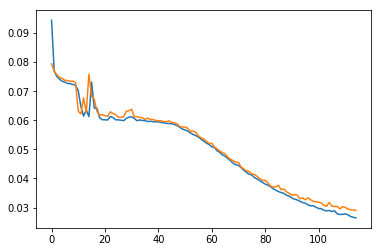

당-----------------시--의--서--시--언 어--도--하--고- 당-시--의- 뫈-신-차--을 다--른 사--람-가- 공-기--할 수 -있-습-니----------------------------------------------------다.<eos><eos>
당시의서시언 어도하고 당시의 뫈신차을 다른 사람가 공기할 수 있습니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


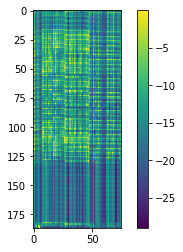

그------------- 사--람-은 시--자--에--에--서- 자--이- 아--알-이--하--ᄅᄅ- 사--람-람-들 주--우--하--이- 안-다---------------------------------------다.<eos><eos>
그 사람은 시자에에서 자이 아알이하ᄅ 사람람들 주우하이 안다다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


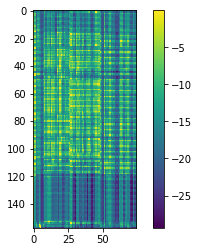

-------------------------------------------------------------------------------------------------------
09-01 18:14:37
Mean Train Loss: 0.027285075656955114
Mean Evaluation Loss: 0.028970217595361586
-------------------------------------------------------------------------------------------------------
09-01 18:14:58
Mean Train Loss: 0.02683489865672285
Mean Evaluation Loss: 0.02924089874940916
-------------------------------------------------------------------------------------------------------
09-01 18:15:18
Mean Train Loss: 0.02730223546619236
Mean Evaluation Loss: 0.029443026538894343
-------------------------------------------------------------------------------------------------------
09-01 18:15:38
Mean Train Loss: 0.02662803651008608
Mean Evaluation Loss: 0.029655318566965974
-------------------------------------------------------------------------------------------------------
09-01 18:15:59
Mean Train Loss: 0.026306644441661187
Mean Evaluation Loss: 0.029097912696780404
----

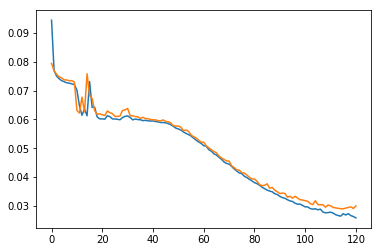

오------------------리--는 --- 금-으--의- 오--우--애--퍼--에  일-럴 절-일-에- 토--아- 십 있-실 벌-가  샌-강-했-어--------------------------------------------------------요.<eos><eos>
오리는  금으의 오우애퍼에 일럴 절일에 토아 십 있실 벌가 샌강했어요.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


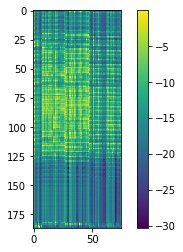

영---------건 가--운 간-연-에  애--우--인 간-건-길-들-사- 어-ᄋ을 반-무--하--고  있----------------------------------------------------------다.<eos><eos>
영건 가운 간연에 애우인 간건길들사 어을 반무하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


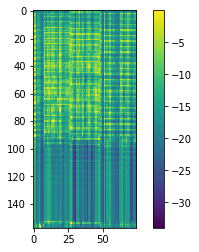

-------------------------------------------------------------------------------------------------------
09-01 18:16:41
Mean Train Loss: 0.026268269622510727
Mean Evaluation Loss: 0.028697751093824563
-------------------------------------------------------------------------------------------------------
09-01 18:17:01
Mean Train Loss: 0.026012516220389484
Mean Evaluation Loss: 0.030439179542474985
-------------------------------------------------------------------------------------------------------
09-01 18:17:21
Mean Train Loss: 0.025949806432058412
Mean Evaluation Loss: 0.028268283542051062
-------------------------------------------------------------------------------------------------------
09-01 18:17:42
Mean Train Loss: 0.025604233198907596
Mean Evaluation Loss: 0.02805401045833819
-------------------------------------------------------------------------------------------------------
09-01 18:18:02
Mean Train Loss: 0.0253010787819901
Mean Evaluation Loss: 0.0284210717448383
-----

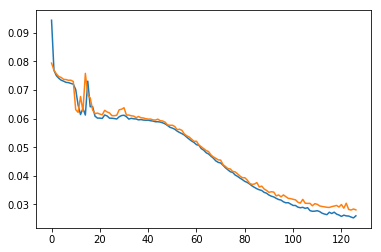

사--름-음-음-은-는 나--는 사--람-을 보--에--테- 솔-을 온-북-항-엔 만-아- 이--가--아- 되--니----------------------------------------------------------------------------다.<eos><eos>
사름음음은는 나는 사람을 보에테 솔을 온북항엔 만아 이가아 되니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


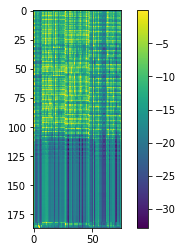

우--리- 하--앙-이--는 애--구--이- 이--년-채--을 이--한-구--구- 관-장-간 아--람-되--아  있-습-니-----------------------------------------------다.<eos><eos>
우리 하앙이는 애구이 이년채을 이한구구 관장간 아람되아 있습니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


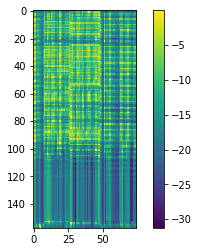

-------------------------------------------------------------------------------------------------------
09-01 18:18:43
Mean Train Loss: 0.024642889617120058
Mean Evaluation Loss: 0.030598291444388605
-------------------------------------------------------------------------------------------------------
09-01 18:19:03
Mean Train Loss: 0.025382235084778316
Mean Evaluation Loss: 0.027221828098486944
-------------------------------------------------------------------------------------------------------
09-01 18:19:23
Mean Train Loss: 0.02541990726144233
Mean Evaluation Loss: 0.028686316153010222
-------------------------------------------------------------------------------------------------------
09-01 18:19:43
Mean Train Loss: 0.024958042959373747
Mean Evaluation Loss: 0.028220588400938114
-------------------------------------------------------------------------------------------------------
09-01 18:20:03
Mean Train Loss: 0.024678483126093154
Mean Evaluation Loss: 0.027355430909621677
-

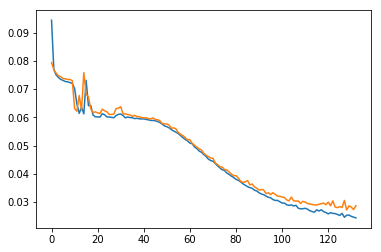

모------ᄅ---라--구- 구--가--한-하--는 송-기- 신-몬-는 오--스--아- 아--난-거--다----- 망-한-이  안-들 대--입-니------------------------------------------------------------다.<eos><eos>
모ᄅ라구 구가한하는 송기 신몬는 오스아 아난거다 망한이 안들 대입니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


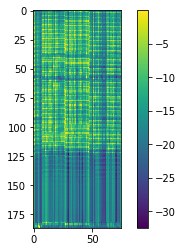

요----------즘-에--는 장-이--이--으--이--이- 안-선-니--님-을 조--영-하--지--잖-으--하--을-이- 많-아-------------------------------------------요.<eos><eos>
요즘에는 장이이으이이 안선니님을 조영하지잖으하을이 많아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


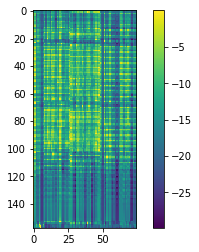

-------------------------------------------------------------------------------------------------------
09-01 18:20:44
Mean Train Loss: 0.02459193844979254
Mean Evaluation Loss: 0.028138138910374005
-------------------------------------------------------------------------------------------------------
09-01 18:21:04
Mean Train Loss: 0.024764336468322354
Mean Evaluation Loss: 0.028354343107353103
-------------------------------------------------------------------------------------------------------
09-01 18:21:25
Mean Train Loss: 0.024172221022553477
Mean Evaluation Loss: 0.028680175372703415
-------------------------------------------------------------------------------------------------------
09-01 18:21:45
Mean Train Loss: 0.02462096763851991
Mean Evaluation Loss: 0.027163128772951423
-------------------------------------------------------------------------------------------------------
09-01 18:22:06
Mean Train Loss: 0.024292726266714262
Mean Evaluation Loss: 0.02695885564430496
---

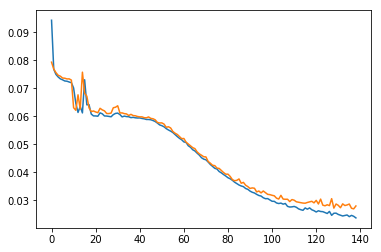

우------------------리--는 이--구- 기--을 자--드--데  건-기--를 도--오--하--기- 위--해- 계--석-테--서- 새--사--을 다--할 고--입-니--------------------------------------------다.<eos><eos>
우리는 이구 기을 자드데 건기를 도오하기 위해 계석테서 새사을 다할 고입니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


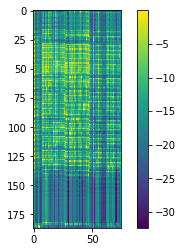

어----------른-한-자--는 우--리--하--아에에--서  가--장 이--기--이--는 내--국 소--선-징 한-아--해-----------------------------------------------요.<eos><eos>
어른한자는 우리하아에에서 가장 이기이는 내국 소선징 한아해요.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


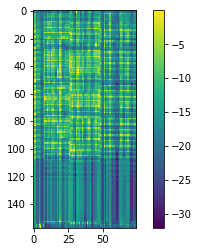

-------------------------------------------------------------------------------------------------------
09-01 18:22:47
Mean Train Loss: 0.024143402746997267
Mean Evaluation Loss: 0.028244947141345463
-------------------------------------------------------------------------------------------------------
09-01 18:23:07
Mean Train Loss: 0.024498163352959137
Mean Evaluation Loss: 0.02761093103561821
-------------------------------------------------------------------------------------------------------
09-01 18:23:27
Mean Train Loss: 0.023883969872995934
Mean Evaluation Loss: 0.027502702577525823
-------------------------------------------------------------------------------------------------------
09-01 18:23:47
Mean Train Loss: 0.02473488366642113
Mean Evaluation Loss: 0.02765201843351006
-------------------------------------------------------------------------------------------------------
09-01 18:24:07
Mean Train Loss: 0.024831343026348516
Mean Evaluation Loss: 0.027929605215991173
---

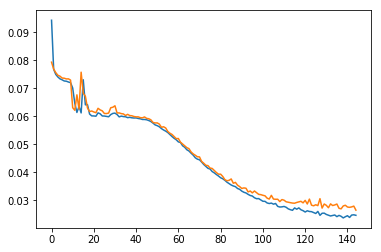

오------늘 히--아--이--가--호--오- 와--안 정-성 가--이--을 하--시--이--데--되- 영-겨--사--을-기---ᅦ  생-강-합-니------------------------------------------------------------다.<eos><eos>
오늘 히아이가호오 와안 정성 가이을 하시이데되 영겨사을기ᅦ 생강합니다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


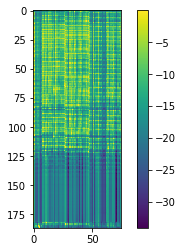

요--즘-제--에--은 푸--성-항-아- 상-들ᄃᄋ에 겅-기--가- 궁-경-한 장-자- 겨--고--가--그  않-아---------------------------------------------------요.<eos><eos>
요즘제에은 푸성항아 상들ᄃ에 겅기가 궁경한 장자 겨고가그 않아요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


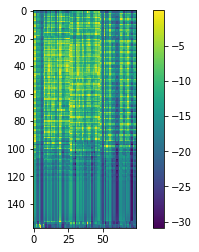

-------------------------------------------------------------------------------------------------------
09-01 18:24:48
Mean Train Loss: 0.02587571960322168
Mean Evaluation Loss: 0.027232614447025322
-------------------------------------------------------------------------------------------------------
09-01 18:25:09
Mean Train Loss: 0.02434058314914087
Mean Evaluation Loss: 0.0270335831811661
-------------------------------------------------------------------------------------------------------
09-01 18:25:29
Mean Train Loss: 0.025413794099381288
Mean Evaluation Loss: 0.027626240805509857
-------------------------------------------------------------------------------------------------------
09-01 18:25:49
Mean Train Loss: 0.02346884443807139
Mean Evaluation Loss: 0.026783316204706743
-------------------------------------------------------------------------------------------------------
09-01 18:26:09
Mean Train Loss: 0.023176918900617936
Mean Evaluation Loss: 0.026836090499638802
-----

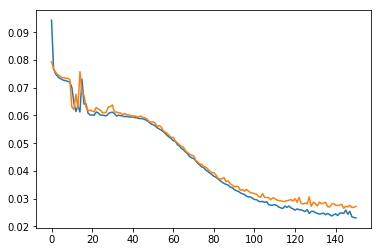

채------ᄀ---그--시--이- 가--에- 뗘- 거--저--기--아--고- 가--려--지--면-서- 고--싱-이--난--ᅳᆫ 여--전-드--니- 느--고  있-어---------------------------------------요.<eos><eos>
채ᄀ그시이 가에 뗘 거저기아고 가려지면서 고싱이난ᅳᆫ 여전드니 느고 있어요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


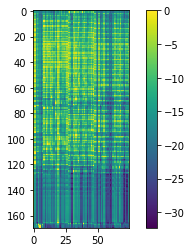

저----------는 으--사--람-에  바--라--여--인 마--잘-ᅳᅳᆯ 대--알 태--도--가- 마--음---ᆫ 안 드--어---------------------------------------------------요.<eos><eos>
저는 으사람에 바라여인 마잘ᅳᆯ 대알 태도가 마음ᆫ 안 드어요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


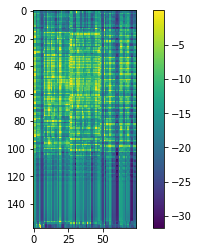

-------------------------------------------------------------------------------------------------------
09-01 18:26:51
Mean Train Loss: 0.02423338689925072
Mean Evaluation Loss: 0.027812180249576962
-------------------------------------------------------------------------------------------------------
09-01 18:27:11
Mean Train Loss: 0.024322630242314496
Mean Evaluation Loss: 0.02757059164792195
-------------------------------------------------------------------------------------------------------
09-01 18:27:31
Mean Train Loss: 0.03206064304980453
Mean Evaluation Loss: 0.02994458221907707
-------------------------------------------------------------------------------------------------------
09-01 18:27:51
Mean Train Loss: 0.02572036154558729
Mean Evaluation Loss: 0.028654186722823733
-------------------------------------------------------------------------------------------------------
09-01 18:28:11
Mean Train Loss: 0.02422621198393989
Mean Evaluation Loss: 0.027400534026324273
------

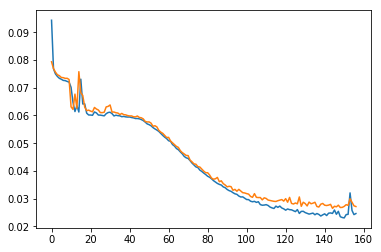

저------------------는 나--진 많-이- 아--러- 새--름-를 사--람-드--에--ᄀ-  마--을 이--였-는 델 많-은 시--각-이  얼-라----------------------------------------------------요.<eos><eos>
저는 나진 많이 아러 새름를 사람드에ᄀ 마을 이였는 델 많은 시각이 얼라요.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


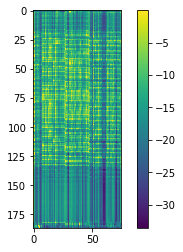

요 -슬-스--스--글 기--그--갈-에- 태--하--우--로ᅩ-토--도--를 고--하--라--고  삭-을 할-쓰--했-어---------------------------------------------------요.<eos><eos>
요 슬스스글 기그갈에 태하우로토도를 고하라고 삭을 할쓰했어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


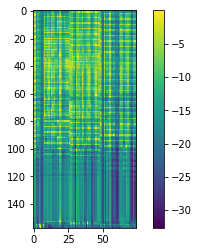

-------------------------------------------------------------------------------------------------------
09-01 18:28:52
Mean Train Loss: 0.02410561456059313
Mean Evaluation Loss: 0.02788829106787404
-------------------------------------------------------------------------------------------------------
09-01 18:29:12
Mean Train Loss: 0.023136529148175336
Mean Evaluation Loss: 0.025783809895530488
-------------------------------------------------------------------------------------------------------
09-01 18:29:32
Mean Train Loss: 0.022138455064775076
Mean Evaluation Loss: 0.026931547357052405
-------------------------------------------------------------------------------------------------------
09-01 18:29:52
Mean Train Loss: 0.025238039867118055
Mean Evaluation Loss: 0.026868266381956257
-------------------------------------------------------------------------------------------------------
09-01 18:30:12
Mean Train Loss: 0.02314166567674263
Mean Evaluation Loss: 0.025884686561188617
---

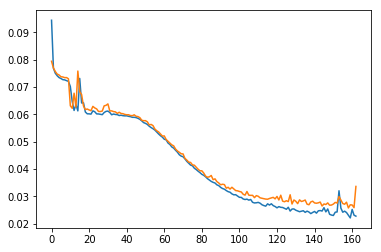

감-------------묵-이- 몇-년 만 평-운 상-곰-나--우--르- 그------는 삼-시--가--을 삽-일-다--고  말-안-고 -었-----------------------------------------------------------다.<eos><eos>
감묵이 몇년 만 평운 상곰나우르 그는 삼시가을 삽일다고 말안고 었다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


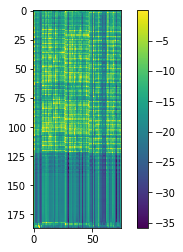

우--------------리- 발-이- 인-는 대--부--우--한 상-둘-디- 올-어--읏 수--시--으- 하--곡-됩-닙-니-----------------------------------------------다.<eos><eos>
우리 발이 인는 대부우한 상둘디 올어읏 수시으 하곡됩닙니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


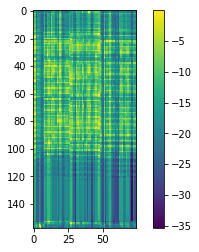

-------------------------------------------------------------------------------------------------------
09-01 18:30:54
Mean Train Loss: 0.027520224497364392
Mean Evaluation Loss: 0.02643328358254728
-------------------------------------------------------------------------------------------------------
09-01 18:31:14
Mean Train Loss: 0.02409847571949304
Mean Evaluation Loss: 0.027626353489774196
-------------------------------------------------------------------------------------------------------
09-01 18:31:34
Mean Train Loss: 0.023642616013521772
Mean Evaluation Loss: 0.026459599843199687
-------------------------------------------------------------------------------------------------------
09-01 18:31:55
Mean Train Loss: 0.022926319690966104
Mean Evaluation Loss: 0.02641718415711451
-------------------------------------------------------------------------------------------------------
09-01 18:32:15
Mean Train Loss: 0.023268726586765136
Mean Evaluation Loss: 0.02695029858412751
----

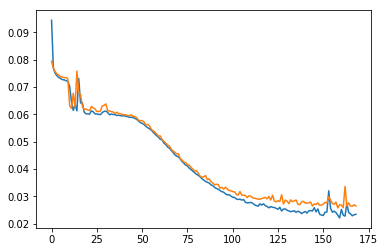

당-------------시--시- 사--사--는 엄-무--도- 함-고- 강-신-아- 가--심-자--을 다--른 사--람-가  공-애--할 수  있-습-니----------------------------------------------------다..<eos>
당시시 사사는 엄무도 함고 강신아 가심자을 다른 사람가 공애할 수 있습니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


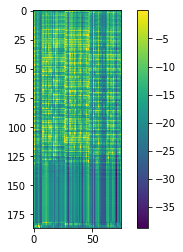

저--------------는 그--사--람-이  바--영-인 면-자-으ᅳᆯ 대--는 대--도--가- 많---ᆷ-ᄋ-  안 들-어---------------------------------------------------요.<eos><eos>
저는 그사람이 바영인 면자을 대는 대도가 많ᆷᄋ 안 들어요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


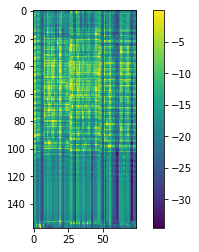

-------------------------------------------------------------------------------------------------------
09-01 18:32:55
Mean Train Loss: 0.023040630672110672
Mean Evaluation Loss: 0.03093987486906487
-------------------------------------------------------------------------------------------------------
09-01 18:33:16
Mean Train Loss: 0.024612727756446667
Mean Evaluation Loss: 0.027073717166799627
-------------------------------------------------------------------------------------------------------
09-01 18:33:36
Mean Train Loss: 0.025425403109721998
Mean Evaluation Loss: 0.026979262245148218
-------------------------------------------------------------------------------------------------------
09-01 18:33:56
Mean Train Loss: 0.023408665568767424
Mean Evaluation Loss: 0.028567686106561057
-------------------------------------------------------------------------------------------------------
09-01 18:34:17
Mean Train Loss: 0.024039930223056536
Mean Evaluation Loss: 0.026272554633862404
-

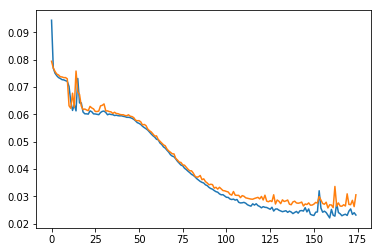

그----------은-은 혼-현 학-작-잔-ᄒᆫᆫ 본-형-하--지-ᄆ만 저--는 이--기--직-으--로  구ᄅ-로--를 좋-아--지  않-아-------------------------------------------요.<eos><eos>
그은은 혼현 학작잔ᄒᆫ 본형하지만 저는 이기직으로 구ᄅ로를 좋아지 않아요.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


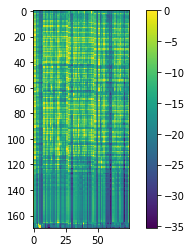

죄--------------송-하--지--만 사--앵-엥-이- 개--핸-은 지--간 가--엔ᄉ사ᅦ-이- 어--는 것-았-습-니-----------------------------------------------다.<eos><eos>
죄송하지만 사앵엥이 개핸은 지간 가엔사ᅦ이 어는 것았습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


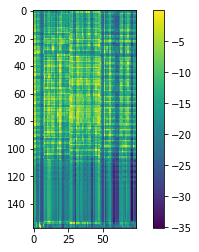

-------------------------------------------------------------------------------------------------------
09-01 18:34:58
Mean Train Loss: 0.023932204796968636
Mean Evaluation Loss: 0.02620921172526976
-------------------------------------------------------------------------------------------------------
09-01 18:35:18
Mean Train Loss: 0.023161431909395763
Mean Evaluation Loss: 0.028083565995232995
-------------------------------------------------------------------------------------------------------
09-01 18:35:38
Mean Train Loss: 0.023446245639072424
Mean Evaluation Loss: 0.0272565498770465
-------------------------------------------------------------------------------------------------------
09-01 18:35:59
Mean Train Loss: 0.0225256798202121
Mean Evaluation Loss: 0.025838276587154513
-------------------------------------------------------------------------------------------------------
09-01 18:36:19
Mean Train Loss: 0.026140475642907474
Mean Evaluation Loss: 0.028177047927862776
-----

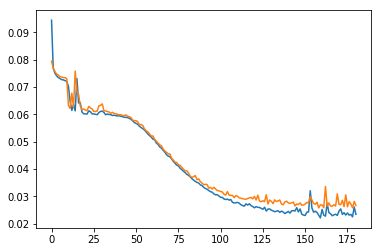

중---------무--에--의- 해- 퍼--풀-을 사--이  하--구--잔-달-뎌---ᅮ- 도--아- 회--하--하--사ᄒ-애--이  멱-한-지  있-습-니--------------------------------------------------------다.<eos><eos>
중무에의 해 퍼풀을 사이 하구잔달뎌ᅮ 도아 회하하사ᄒ애이 멱한지 있습니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


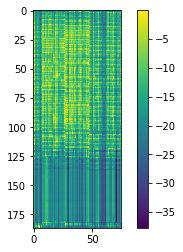

저------는 진-이--으- 적-가--ᄅᄅ- 고  지--언-는 것-보--다  코--쿠--른 친 는 게- 한-해-----------------------------------------------------------요.<eos><eos>
저는 진이으 적가ᄅ 고 지언는 것보다 코쿠른 친 는 게 한해요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


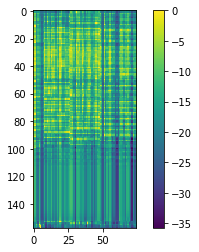

-------------------------------------------------------------------------------------------------------
09-01 18:37:00
Mean Train Loss: 0.023603569809073632
Mean Evaluation Loss: 0.029520295191416815
-------------------------------------------------------------------------------------------------------
09-01 18:37:20
Mean Train Loss: 0.024967487100788322
Mean Evaluation Loss: 0.026809814228373648
-------------------------------------------------------------------------------------------------------
09-01 18:37:40
Mean Train Loss: 0.02278414797772826
Mean Evaluation Loss: 0.026350162475075815
-------------------------------------------------------------------------------------------------------
09-01 18:38:00
Mean Train Loss: 0.022917581646616954
Mean Evaluation Loss: 0.02712041060513563
-------------------------------------------------------------------------------------------------------
09-01 18:38:20
Mean Train Loss: 0.02335295686124897
Mean Evaluation Loss: 0.026915646875662544
---

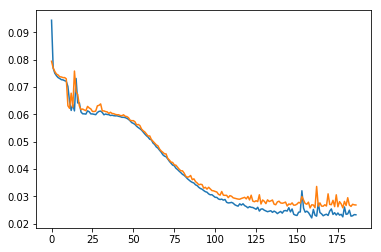

우----------리--는 천-번-의  무--진-녕-에  해--사--안 십-한 이--해  많-은 고--인-딜-을 지--워--회--핬-습-니-------------------------------------------다.<eos><eos>
우리는 천번의 무진녕에 해사안 십한 이해 많은 고인딜을 지워회핬습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


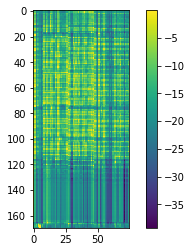

인-------------나--에--는 하--새--으--을 송-간-가--을 자--고ᄃ-데--은 산-생-임-들-이  있-었-어-----------------------------------------------요.<eos><eos>
인나에는 하새으을 송간가을 자고ᄃ데은 산생임들이 있었어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


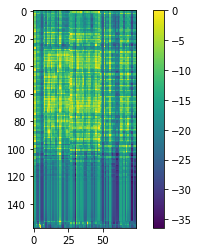

-------------------------------------------------------------------------------------------------------
09-01 18:39:01
Mean Train Loss: 0.02286580277381772
Mean Evaluation Loss: 0.03518189026653605
-------------------------------------------------------------------------------------------------------
09-01 18:39:21
Mean Train Loss: 0.03194467347739587
Mean Evaluation Loss: 0.027850032065880874
-------------------------------------------------------------------------------------------------------
09-01 18:39:42
Mean Train Loss: 0.024966957742078546
Mean Evaluation Loss: 0.02840657155067377
-------------------------------------------------------------------------------------------------------
09-01 18:40:02
Mean Train Loss: 0.024244768912923098
Mean Evaluation Loss: 0.026633031123540103
-------------------------------------------------------------------------------------------------------
09-01 18:40:22
Mean Train Loss: 0.023070083023927393
Mean Evaluation Loss: 0.025837160674937635
----

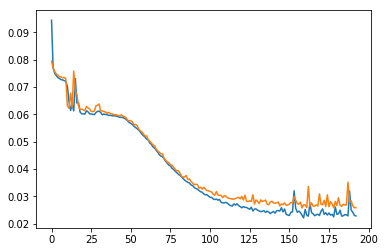

여----------언-으--는 입-웃-세--서- ----------ᆸ--ᅵ, --, 백-----타, 큘-----랩-대, 다--양-안 정-ᄌᆼᆼ-이- 곤-대--를 보--실 수 -있-습-니-------------------다..<eos>
여언으는 입웃세서 ᆸᅵ, , 백타, 큘랩대, 다양안 정ᄌᆼ이 곤대를 보실 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


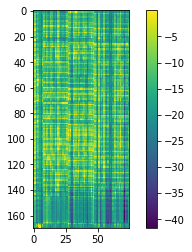

요----------짐-에--는 후--중-마- 화- 사--트ᄋ-이  경-기ᄀᄀ가  븡-녕-한 장-이--경-오--가  않-나---------------------------------------------------요.<eos><eos>
요짐에는 후중마 화 사트ᄋ이 경기가 븡녕한 장이경오가 않나요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


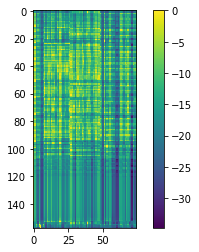

-------------------------------------------------------------------------------------------------------
09-01 18:41:03
Mean Train Loss: 0.02578855630232785
Mean Evaluation Loss: 0.04692441569610954
-------------------------------------------------------------------------------------------------------
09-01 18:41:24
Mean Train Loss: 0.036613642910392104
Mean Evaluation Loss: 0.03027835750267542
-------------------------------------------------------------------------------------------------------
09-01 18:41:44
Mean Train Loss: 0.02707159697941288
Mean Evaluation Loss: 0.027799845341372403
-------------------------------------------------------------------------------------------------------
09-01 18:42:04
Mean Train Loss: 0.024561660606505165
Mean Evaluation Loss: 0.02639070202483949
-------------------------------------------------------------------------------------------------------
09-01 18:42:24
Mean Train Loss: 0.0249532283646463
Mean Evaluation Loss: 0.026406995138820628
-------

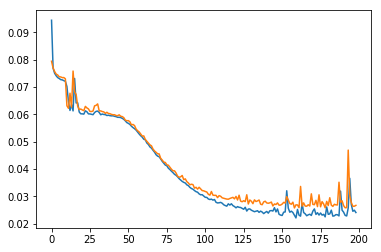

우----------리--는 천-불-읠 고--신-년-에  회--사--를 설-립-할-게  많-는 애--목-긴-기--를 지--어--아--았-습-니--------------------------------------------------------다..<eos>
우리는 천불읠 고신년에 회사를 설립할게 많는 애목긴기를 지어아았습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


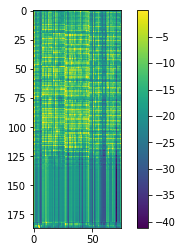

저------는 ----심-은 저--가--랄-로ᅩ 지--언-은-는 것-보--가  코--부--리--진-는 히  한-내-------------------------------------------------------요.<eos><eos>
저는 심은 저가랄로 지언은는 것보가 코부리진는 히 한내요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


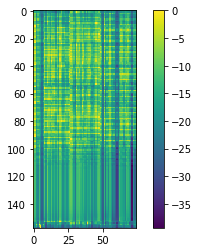

-------------------------------------------------------------------------------------------------------
09-01 18:43:05
Mean Train Loss: 0.02727944125372508
Mean Evaluation Loss: 0.032070191506807684
-------------------------------------------------------------------------------------------------------
09-01 18:43:25
Mean Train Loss: 0.046747883805726476
Mean Evaluation Loss: 0.03808781605145134
-------------------------------------------------------------------------------------------------------
09-01 18:43:45
Mean Train Loss: 0.03454998087319328
Mean Evaluation Loss: 0.03102670854219114
-------------------------------------------------------------------------------------------------------
09-01 18:44:05
Mean Train Loss: 0.029561180479399946
Mean Evaluation Loss: 0.02870700639810912
-------------------------------------------------------------------------------------------------------
09-01 18:44:25
Mean Train Loss: 0.027478288403682407
Mean Evaluation Loss: 0.028063292397916436
-----

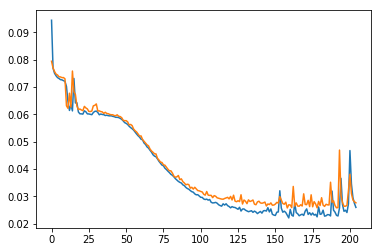

기----------중-푸--이--소--도--러--만-사--어- 우--을 정-전-공-아- 이--주--블ᅡ한-을 사--심-을 긷-었-었-어-----------------------------------------------요.<eos><eos>
기중푸이소도러만사어 우을 정전공아 이주블ᅡ한을 사심을 긷었었어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


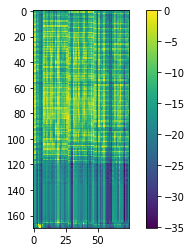

내------------- 시--각-기--는 애--걱-을 다--려--는 대--는 피--이--항-이ᅦ 이--는 것 같----------------------------------------------------------다.<eos><eos>
내 시각기는 애걱을 다려는 대는 피이항이ᅦ 이는 것 같다.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


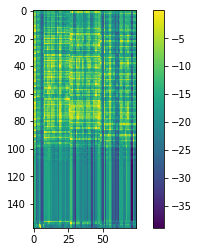

-------------------------------------------------------------------------------------------------------
09-01 18:45:07
Mean Train Loss: 0.028871299795078204
Mean Evaluation Loss: 0.029736740074236285
-------------------------------------------------------------------------------------------------------
09-01 18:45:27
Mean Train Loss: 0.028229858678408937
Mean Evaluation Loss: 0.030159469797996673
-------------------------------------------------------------------------------------------------------
09-01 18:45:47
Mean Train Loss: 0.027528065644686302
Mean Evaluation Loss: 0.0280920623754569
-------------------------------------------------------------------------------------------------------
09-01 18:46:07
Mean Train Loss: 0.026533652630962586
Mean Evaluation Loss: 0.02713962331088405
-------------------------------------------------------------------------------------------------------
09-01 18:46:27
Mean Train Loss: 0.025295386039957343
Mean Evaluation Loss: 0.026297412841586924
---

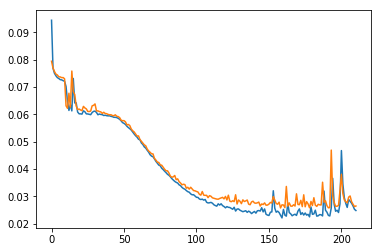

저----------의- 아--장-에  모--들 퐁-보--이  이--먼 기--인-최--오- 삼-ᄉ---피--퍼--태--타--자--지  하--을 팜-마--를 납-니----------------------------------------------------다.<eos><eos>
저의 아장에 모들 퐁보이 이먼 기인최오 삼ᄉ피퍼태타자지 하을 팜마를 납니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


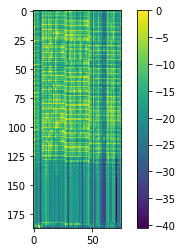

한---------국-의- 고--오--들-는 자--신-을-에--에  너--문 많-는 것-일 이--갈 근 같 앝-아---------------------------------------------------요.<eos><eos>
한국의 고오들는 자신을에에 너문 많는 것일 이갈 근 같 앝아요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


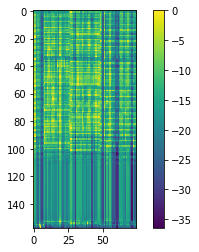

-------------------------------------------------------------------------------------------------------
09-01 18:47:08
Mean Train Loss: 0.024903603070199353
Mean Evaluation Loss: 0.02634725426170293
-------------------------------------------------------------------------------------------------------
09-01 18:47:28
Mean Train Loss: 0.02463364387514766
Mean Evaluation Loss: 0.026698338859103422
-------------------------------------------------------------------------------------------------------
09-01 18:47:48
Mean Train Loss: 0.03089302124317249
Mean Evaluation Loss: 0.029027254825832377
-------------------------------------------------------------------------------------------------------
09-01 18:48:08
Mean Train Loss: 0.026536614882665507
Mean Evaluation Loss: 0.02791165776957804
-------------------------------------------------------------------------------------------------------
09-01 18:48:28
Mean Train Loss: 0.02544857941113985
Mean Evaluation Loss: 0.027010475524641926
-----

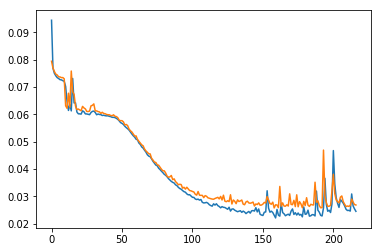

그----------녀--는 자--인 지--내--의- 이--영-개  명-혀--아- 브--른 주--만-늘 대--는 아--로- 간-심-이  없-었---------------------------------------------------------------다.<eos><eos>
그녀는 자인 지내의 이영개 명혀아 브른 주만늘 대는 아로 간심이 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


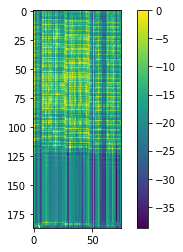

요--------------즘-에--은 자--기--기--도--인-이- 아--아--다--임-은---- 종-경-가  자--는-ᅡᅡᆭ-이--드--므  많-아-----------------------------------요.<eos><eos>
요즘에은 자기기도인이 아아다임은 종경가 자는ᅡᆭ이드므 많아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


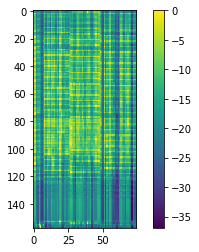

-------------------------------------------------------------------------------------------------------
09-01 18:49:10
Mean Train Loss: 0.02430785706174315
Mean Evaluation Loss: 0.027633072027871627
-------------------------------------------------------------------------------------------------------
09-01 18:49:30
Mean Train Loss: 0.025133839420351432
Mean Evaluation Loss: 0.026338966896219326
-------------------------------------------------------------------------------------------------------
09-01 18:49:50
Mean Train Loss: 0.02453284438218764
Mean Evaluation Loss: 0.028562095629190504
-------------------------------------------------------------------------------------------------------
09-01 18:50:10
Mean Train Loss: 0.02561874139944951
Mean Evaluation Loss: 0.026157239236005863
-------------------------------------------------------------------------------------------------------
09-01 18:50:31
Mean Train Loss: 0.030383846936609036
Mean Evaluation Loss: 0.038323538189503195
---

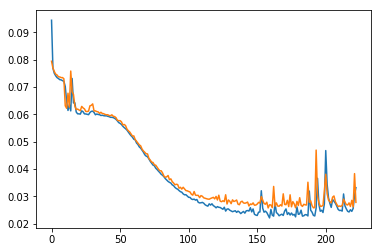

당------------------ᄉ시ᅵ읜ᄉ산진을 어-로--도-하ᅡᄀ고ᅩ  가--시-긔ᅴ- 마-신ᆫ자ᅡ-를  다--ᄂ는 사-라ᅡ가-  ᅩᅩᆼ애ᄒ하 수 있습니ᅵ-------------------------------------------------------다.<eos><eos>
당시읜산진을 어로도하고 가시긔 마신자를 다는 사라가 ᅩᆼ애하 수 있습니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


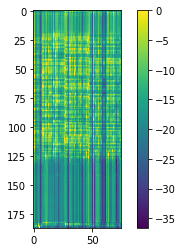

죄-------------ᄉ송하-ᄌ지ᄆ만ᆫ  서---생ᆼ이-의  계-애-으ᅳᆫ 시--ᄀ우  바ᅡ은ᄉ사ᄋ이 어-는 것갔-습ᆸ니ᅵ---------------------------------------------------다.<eos><eos>
죄송하지만 서생이의 계애은 시ᄀ우 바은사이 어는 것갔습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


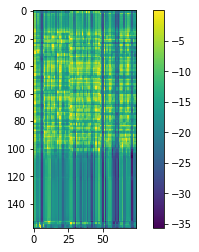

-------------------------------------------------------------------------------------------------------
09-01 18:51:12


KeyboardInterrupt: ignored

In [33]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_3')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_test.initialize_batch()
    loss_list_eval = list()
    
    while preloader_test.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_test.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_3')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_3.npy', loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_3.npy', loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")